# Programming Exercise 8:
# Anomaly Detection 


## Introduction 

In this exercise, you will implement the anomaly detection algorithm and
apply it to detect failing servers on a network. 

Before we begin with the exercises, we need to import all libraries required for this programming exercise. We will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions and others
import utils



# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Anomaly Detection 

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

We start this exercise by using a small dataset that is easy to visualize. Our example case consists of 2 network server statistics across several machines: the latency and throughput of each machine. 

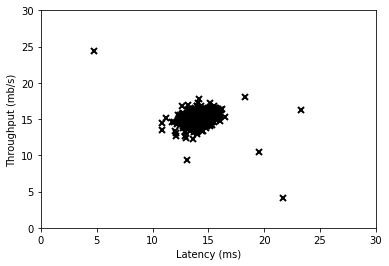

In [2]:
#  The following command loads the dataset.
data = loadmat(os.path.join('Data', 'ex8data1.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

#  Visualize the example dataset
pyplot.plot(X[:, 0], X[:, 1], 'bx', mew=2, mec='k', ms=6)
pyplot.axis([0, 30, 0, 30])
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pass

### 1.1 Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), you want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 \dots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$  that fit the data in the $i^{th}$ dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{th}$ dimension of each example).

The Gaussian distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

<a id="section1"></a>
### 1.2 Estimating parameters for a Gaussian 

You can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, you will use: 

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance you will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

Your task is to complete the code in the function `estimateGaussian`. This function takes as input the data matrix `X` and should output an n-dimension vector `mu` that holds the mean for each of the $n$ features and another n-dimension vector `sigma2` that holds the variances of each of the features. You can implement this
using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer). 
<a id="estimateGaussian"></a>

In [3]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    
    Instructions
    ------------
    Compute the mean of the data and the variances
    In particular, mu[i] should contain the mean of
    the data for the i-th feature and sigma2[i]
    should contain variance of the i-th feature.
    """
    # Useful variables
    m, n = X.shape

    # You should return these values correctly
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    # ====================== YOUR CODE HERE ======================
    mu=1/m * np.sum(X , axis=0)
    sigma2=1/m *np.sum((X-mu)**2,axis=0)
    
    # =============================================================
    return mu, sigma2

Once you have completed the code in `estimateGaussian`, the next cell will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to the figure below.

![](Figures/gaussian_fit.png)

From your plot, you can see that most of the examples are in the region with the highest probability, while
the anomalous examples are in the regions with lower probabilities.

To do the visualization of the Gaussian fit, we first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

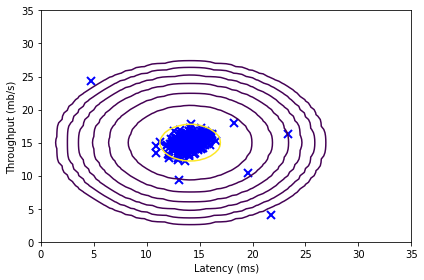

In [4]:
#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = utils.multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
utils.visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()

<a id="section2"></a>
### 1.3 Selecting the threshold, $\varepsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.


You should now complete the code for the function `selectThreshold`. For this, we will use a cross validation set $\{ (x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p\left( x_{cv}^{(i)}\right)$. The vector of all of these probabilities $p\left( x_{cv}^{(1)}\right), \dots, p\left( x_{cv}^{(m_{cv})}\right)$ is passed to `selectThreshold` in the vector `pval`. The corresponding labels $y_{cv}^{(1)} , \dots , y_{cv}^{(m_{cv})}$ are passed to the same function in the vector `yval`.

The function `selectThreshold` should return two values; the first is the selected threshold $\varepsilon$. If an example $x$ has a low probability $p(x) < \varepsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you are doing on finding the ground truth
anomalies given a certain threshold. For many different values of $\varepsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

You compute precision and recall by: 

$$ prec = \frac{tp}{tp + fp}  $$ 

$$ rec = \frac{tp}{tp + fn} $$

where: 

- $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.

-  $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code `selectThreshold`, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. You should now complete the code in `selectThreshold`. You can implement the computation of the $F_1$ score using a for-loop over all the cross
validation examples (to compute the values $tp$, $fp$, $fn$). You should see a value for `epsilon` of about 8.99e-05.

<div class="alert alert-block alert-warning">
**Implementation Note:** In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples. This can be implemented by numpy's equality test
between a vector and a single number. If you have several binary values in an n-dimensional binary vector $v \in \{0, 1\}^n$, you can find out how many values in this vector are 0 by using: np.sum(v == 0). You can also
apply a logical and operator to such binary vectors. For instance, let `cvPredictions` be a binary vector of  size equal to the number of cross validation set, where the $i^{th}$ element is 1 if your algorithm considers
$x_{cv}^{(i)}$ an anomaly, and 0 otherwise. You can then, for example, compute the number of false positives using: `fp = np.sum((cvPredictions == 1) & (yval == 0))`.
</div>
<a id="selectThreshold"></a>

In [11]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.
    
    Parameters
    ----------
    yval : array_like
        The ground truth labels of shape (m, ).
    
    pval : array_like
        The precomputed vector of probabilities based on mu and sigma2 parameters. It's shape is also (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
    
    Instructions
    ------------
    Compute the F1 score of choosing epsilon as the threshold and place the
    value in F1. The code at the end of the loop will compare the
    F1 score for this choice of epsilon and set it to be the best epsilon if
    it is better than the current choice of epsilon.
    
    Notes
    -----
    You can use predictions = (pval < epsilon) to get a binary vector
    of 0's and 1's of the outlier predictions
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        # ====================== YOUR CODE HERE =======================
            predictions = (pval < epsilon)
            tp=np.sum((predictions == 1) & (yval == 1))
            fp=np.sum((predictions == 1) & (yval == 0))
            fn = np.sum((predictions == 0) & (yval == 1))
            prec=tp/(tp+fp)
            rec=tp/(tp+fn)
            F1=(2*prec*rec)/(prec+rec)
            

        # =============================================================
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon

    return bestEpsilon, bestF1

Once you have completed the code in `selectThreshold`, the next cell will run your anomaly detection code and circle the anomalies in the plot.

Best epsilon found using cross-validation: 9.00e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


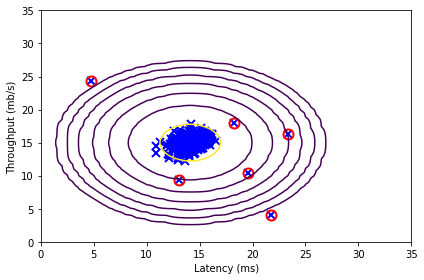

In [12]:
pval = utils.multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Visualize the fit
utils.visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()

#  Draw a red circle around those outliers
pyplot.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

### 1.4 High dimensional dataset

The next cell will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers, but only some features indicate whether a point is an outlier. The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the training data `X` from which you estimated the Gaussian parameters, and do so for the the cross-validation set `Xval`. Finally, it will use `selectThreshold` to find the best threshold $\varepsilon$. You should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In [13]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = loadmat(os.path.join('Data', 'ex8data2.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

# Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = utils.multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = utils.multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set          : %f\n' % F1)
print('  (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of      0.615385)')
print('\n# Outliers found: %d' % np.sum(p < epsilon))

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set          : 0.615385

  (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of      0.615385)

# Outliers found: 117
